In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root_scalar

In [2]:
df = pd.read_excel('./data.xlsx')
df


,Si1,Li1,Si2,Li2,Si3,Li3,Si4,Li4,Si5,Li5,Si6,Li6,Si7,Li7
0,-33.7,-33.700,-37.7,-37.700,-40.7,-40.700,-43.7,-43.700,-47.7,-47.700,-51.7,-51.700,-53.7,-53.700
1,93.0,2.504,74.3,1.888,65.6,1.538,56.3,1.216,51.0,0.960,47.3,0.816,45.7,0.805
2,91.5,2.580,71.0,1.804,62.6,1.503,55.0,1.173,50.4,0.973,45.7,0.770,44.7,0.786
3,97.4,2.776,74.1,1.926,64.4,1.509,58.9,1.290,51.8,0.993,48.5,0.863,47.0,0.801
4,95.0,2.734,73.5,1.914,63.5,1.515,58.0,1.269,51.8,0.993,47.4,0.843,45.9,0.831
5,90.5,2.542,70.5,1.809,62.3,1.518,56.2,1.191,50.5,0.977,46.3,0.815,45.8,0.806
6,97.0,2.805,74.5,1.910,65.0,1.547,57.0,1.212,52.2,1.006,48.2,0.864,46.7,0.797
7,95.5,2.635,73.6,1.813,63.3,1.526,57.5,1.235,52.1,1.021,47.3,0.821,45.1,0.832
8,94.0,2.654,72.7,1.836,62.1,1.484,55.7,1.206,50.0,0.989,45.2,0.793,45.2,0.792
9,94.6,2.725,73.8,1.844,65.0,1.544,57.8,1.230,52.4,1.051,48.2,0.826,46.2,0.830


In [3]:
# Organize into native dict for easy iterability
# Create a dict with So as key, and values as dicts with keys 'Si' and 'Li' (numbers removed)
data = {}
columns = list(df.columns)

for i in range(0, len(columns), 2):
    col1 = columns[i]
    col2 = columns[i+1]
    So = df.iloc[0, i]
    # Remove digits from column names to get 'Si' and 'Li'
    key1 = ''.join([c for c in col1 if not c.isdigit()])
    key2 = ''.join([c for c in col2 if not c.isdigit()])
    values1 = df.iloc[1:, i].tolist()
    values2 = df.iloc[1:, i+1].tolist()
    data[So] = {
        key1: values1,
        key2: values2
    }

# Average measurements
averageData = {}

for So, dataDict in data.items():
    averageData[So] = {}
    for measure, dataList in dataDict.items():
        averageData[So][measure] = np.mean(dataList)
    print(So, averageData[So])

-33.7 {'Si': np.float64(94.27777777777777), 'Li': np.float64(2.6616666666666666)}
-37.7 {'Si': np.float64(73.11111111111111), 'Li': np.float64(1.8604444444444443)}
-40.7 {'Si': np.float64(63.75555555555555), 'Li': np.float64(1.5204444444444443)}
-43.7 {'Si': np.float64(56.93333333333333), 'Li': np.float64(1.2246666666666668)}
-47.7 {'Si': np.float64(51.355555555555554), 'Li': np.float64(0.9958888888888888)}
-51.7 {'Si': np.float64(47.12222222222222), 'Li': np.float64(0.8234444444444443)}
-53.7 {'Si': np.float64(45.81111111111111), 'Li': np.float64(0.808888888888889)}


Focal length f = 24.82 ± 0.02
Intersection at x = -49.6310, y = 49.6310


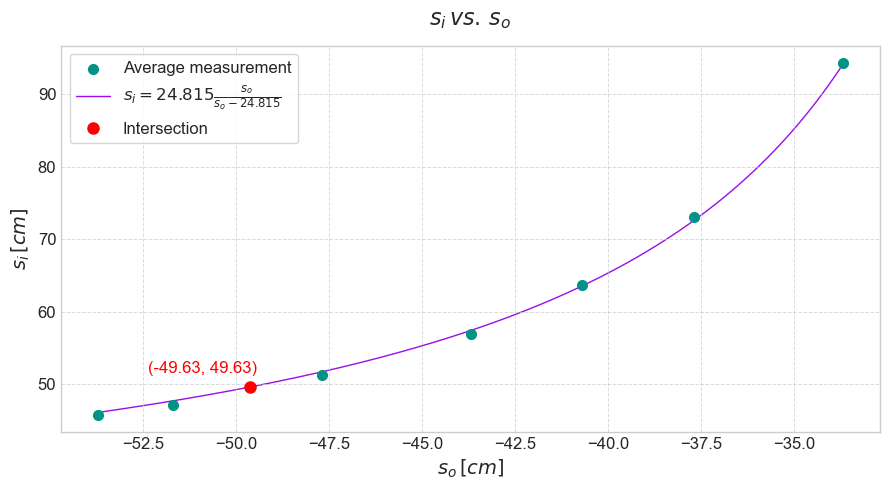

In [5]:
# Si vs So
def lens_eq(so, f):
    return f * (-so) / (-so - f)

so = list(averageData.keys())
si = [i.get('Si') for i in averageData.values()]
space = np.linspace(min(so), max(so), 500)

popt, pcov = curve_fit(lens_eq, so, si)
f_fit = popt[0]
f_err = np.sqrt(pcov[0, 0])

# Find x where lens_eq(x, f_fit) = -x
def eq_to_solve(x):
    return lens_eq(x, f_fit) + x

# Find intersection numerically
sol = root_scalar(eq_to_solve, bracket=[min(so), max(so)])
intersection_x = sol.root if sol.converged else None
intersection_y = lens_eq(intersection_x, f_fit) if intersection_x is not None else None

print(f"Focal length f = {f_fit:.2f} ± {f_err:.2f}")
if intersection_x is not None:
    print(f"Intersection at x = {intersection_x:.4f}, y = {intersection_y:.4f}")
else:
    print("No intersection found in the given interval.")

plt.style.use('seaborn-v0_8-whitegrid')  # Modern style
fig, ax = plt.subplots(figsize=(9, 5))

ax.scatter(so, si, marker='o', linewidth=2, color='xkcd:teal', label='Average measurement', zorder=1)
ax.plot(space, lens_eq(space, f_fit), linewidth=1, color='xkcd:violet', zorder=0, label=rf'$s_i = {f_fit:.3f} \frac{{s_o}}{{s_o - {f_fit:.3f}}}$')
# ax.plot(space, -space, linestyle='--', color='gray', label='$s_i = -s_o$')
if intersection_x is not None:
    ax.plot(intersection_x, intersection_y, 'ro', markersize=8, label='Intersection')
    ax.annotate(f"({intersection_x:.2f}, {intersection_y:.2f})", (intersection_x, intersection_y), textcoords="offset points", xytext=(5,10), ha='right', fontsize=12, color='red')
ax.set_xlabel(r'$s_o \, [cm]$', fontsize=14)
ax.set_ylabel(r'$s_i \, [cm]$', fontsize=14)
ax.set_title(r'$s_i \, vs. \, s_o$', fontsize=16, fontweight='bold', pad=15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend(fontsize=12, loc='best', frameon=True)
plt.tight_layout()
plt.savefig('Srel.png', dpi=300)
plt.show()

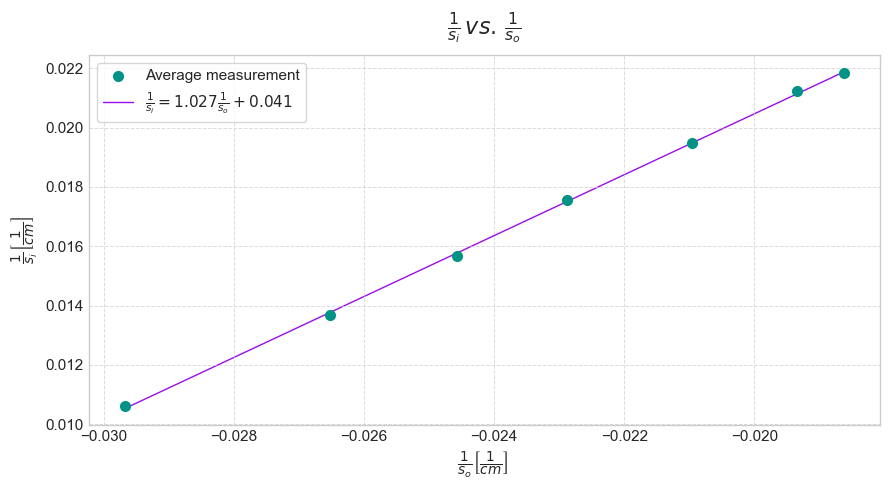

In [6]:
# 1/Si vs 1/So
soInv = [1/i for i in list(averageData.keys())]
siInv = [1/i.get('Si') for i in averageData.values()]

m, b = np.polyfit(soInv, siInv, deg=1)
space = np.linspace(min(soInv), max(soInv), 100)

plt.style.use('seaborn-v0_8-whitegrid')  # Modern style
fig, ax = plt.subplots(figsize=(9, 5))

ax.scatter([1/i for i in list(averageData.keys())], [1/i.get('Si') for i in averageData.values()], marker='o', linewidth=2, color='xkcd:teal', label='Average measurement', zorder=1)
ax.plot(space, space * m + b, linewidth=1, color='xkcd:violet', zorder= 0, label=rf'$\frac{{1}}{{s_i}} = {m:.3f} \frac{{1}}{{s_o}} + {b:.3f}$')
ax.set_xlabel(r'$\frac{1}{s_o} \left [ \frac{1}{cm} \right ]$ ', fontsize=14)
ax.set_ylabel(r'$\frac{1}{s_i} \left [ \frac{1}{cm} \right ]$', fontsize=14)
ax.set_title(r'$\frac{1}{s_i} \, vs. \, \frac{1}{s_o}$', fontsize=16, fontweight='bold', pad=15)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend(fontsize=11, loc='best', frameon=True)
plt.tight_layout()
plt.savefig('InvS.png', dpi=300)
plt.show()

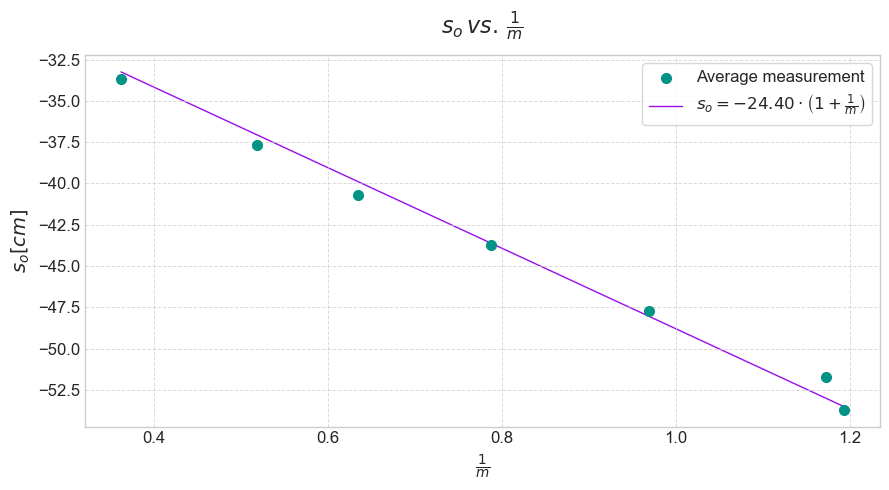

In [34]:
# m
h = 0.965
for dataDict in averageData.values(): dataDict['m'] = dataDict['Li']/h

mInv = [1/i.get('m') for i in averageData.values()]

def soMInv(m, si):
    return si * m

# Model B (thin lens): s_o = f * (1 + 1/m)  (fits focal length f)
def model_thin_lens(inv_m, f):
    # inv_m is 1/m
    return f * (1.0 + inv_m)

space = np.linspace(min(mInv), max(mInv), 500)
popt, pcov = curve_fit(soMInv, mInv, so)
popt2, pcov2 = curve_fit(model_thin_lens, mInv, so)

# so vs 1/m
plt.style.use('seaborn-v0_8-whitegrid')  # Modern style
fig, ax = plt.subplots(figsize=(9, 5))

ax.scatter(mInv, so, marker='o', linewidth=2, color='xkcd:teal', label='Average measurement', zorder=1)
# ax.plot(space, soMInv(space, popt[0]), linewidth=1, color='xkcd:violet', zorder= 0, label=rf'$s_o =  \frac{{1}}{{s_i}} + $')
ax.plot(space, model_thin_lens(space, popt2[0]), linewidth=1, color='xkcd:violet', zorder= 0, label=rf'$s_o = {popt2[0]:.2f} \cdot \left(1+\frac{{1}}{{m}}\right)$')
ax.set_ylabel('$s_o [cm]$', fontsize=14)
ax.set_xlabel(r'$\frac{1}{m}$', fontsize=14)
ax.set_title(r'$s_o \, vs. \, \frac{1}{m}$', fontsize=16, fontweight='bold', pad=15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend(fontsize=12, loc='best', frameon=True)
plt.tight_layout()
plt.savefig('SoM.png', dpi=300)
plt.show()

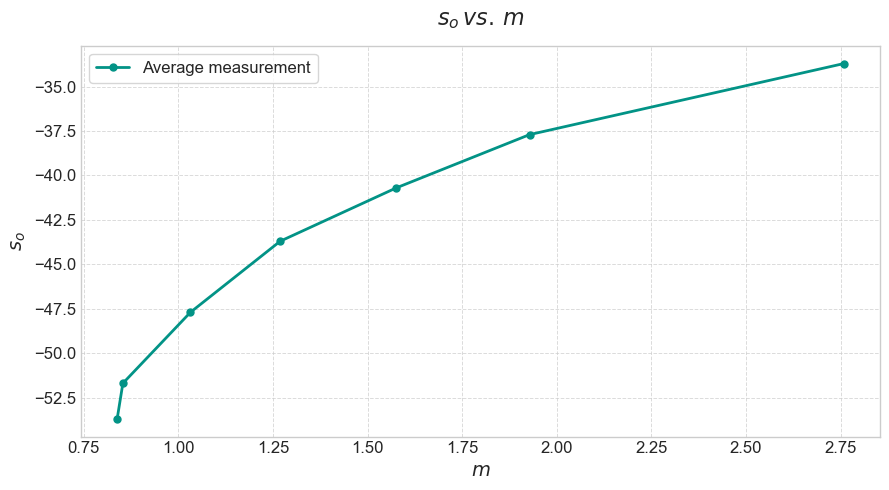

In [35]:
# so vs 1/m
plt.style.use('seaborn-v0_8-whitegrid')  # Modern style
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot([i.get('m') for i in averageData.values()], list(averageData.keys()), marker='.', markersize=10, linewidth=2, color='xkcd:teal', label='Average measurement')
ax.set_ylabel('$s_o$', fontsize=14)
ax.set_xlabel(r'$m$', fontsize=14)
ax.set_title(r'$s_o \, vs. \, m$', fontsize=16, fontweight='bold', pad=15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend(fontsize=12, loc='best', frameon=True)
plt.tight_layout()
plt.show()